## Genome design
- Node genes: neuron in the neural network
- Connection genes: connections between nodes, each with innovation numbers
- Genomes: a complete neural network (phenotype) that stores all child connection and node genes

In [33]:
# import dependencies
import random
import networkx as nx
import matplotlib.pyplot as plt

In [34]:
"""
represents a capability of the system 
ex: firing capability, wind speed
"""
class NodeGene:
    def __init__(self, id, layer, activation, bias):
        self.id = id
        self.layer = layer # layer node belongs to (input, hidden, output)
        self.activation = activation
        self.bias = bias

"""
represents a rule that utilizes the capability
ex: wind speed (input node A) increases (connection) firing capability (output node B)
"""
class NodeConnection:
    def __init__(self, id, output_node_id, input_node_id, weight, enabled, innovation):
        self.id = id
        self.output_node_id = output_node_id
        self.input_node_id = input_node_id
        self.weight = weight
        self.enabled = enabled # disabled gene?
        self.innovation = innovation # id tracks when the connection first showed up in evolutionary history

"""
represents the entire rule book for a team
ex: doctrine manual for red team vs blue team or a single vessel
"""
class Genome:
    def __init__(self, nodes, connections):
        self.nodes = {node.id: node for node in nodes} # each node keyed by id
        self.connections = {conn.innovation: conn for conn in connections} # each connection is keyed by innovation
        self.fitness = 0

## Crossover algorithm
Perform crossover between two parent genomes to derive a new child genome that inherits structures from the parent

In [35]:

"""
finds the child connection set
input: parent_a and parent_b genomes
output: child genome
"""
def crossover(parent_a, parent_b):
    parent_fittest = find_fittest_parent(parent_a, parent_b)

    # get set of innovation numbers of parents
    inn_num_parent_a = set(parent_a.connections.keys())
    inn_num_parent_b = set(parent_b.connections.keys())

    matching = inn_num_parent_a & inn_num_parent_b
    only_in_a = inn_num_parent_a - inn_num_parent_b
    only_in_b = inn_num_parent_b - inn_num_parent_a

    # iterate over all innovation numbers
    # collect the node connections in child
    child_node_connections = []
    
    for innovation in matching | only_in_a | only_in_b:
        # 1. matching nums: random selection of gene
        if (innovation in matching):
            random_connection = random.choice([parent_a.connections[innovation], parent_b.connections[innovation]])
            child_node_connections.append(random_connection)
        # 2. include if disjoint/excess in fitter parent
        elif (innovation in parent_fittest.connections):
            child_node_connections.append(parent_fittest.connections[innovation])
        # 3. dont include if disjoint/excess in less fit parent
        else:
            continue

    # collect child nodes expressed
    child_node_ids = set()
    for conn in child_node_connections:
        child_node_ids.add(conn.input_node_id)
        child_node_ids.add(conn.output_node_id)
    
    child_nodes = [parent_fittest.nodes[node_id] for node_id in child_node_ids]

    # build child genome
    child = Genome(
        nodes = child_nodes,
        connections = child_node_connections
    )

    return child

"""
finds the fitter parent based on fitness score
input: parent_a and parent_b genomes
output: fitter parent genome
"""
def find_fittest_parent(a, b):
    return a if a.fitness >= b.fitness else b

"""
generates a graph visualization of genome
"""
def visualize_genome(genome, ax=None):
    G = nx.DiGraph()

    # create edge for each enabled connection
    for conn in genome.connections.values():
        if conn.enabled:
            G.add_edge(conn.input_node_id, conn.output_node_id)
    
    # draw force directed graph
    if ax is None:
        nx.draw(G, with_labels=True, arrows=True)
        plt.show()
    else:
        nx.draw(G, ax=ax, with_labels=True, arrows=True)

## test matching algorithm
expected: 

child innovations:  [1, 2]
child node ids:  [1, 2, 3]


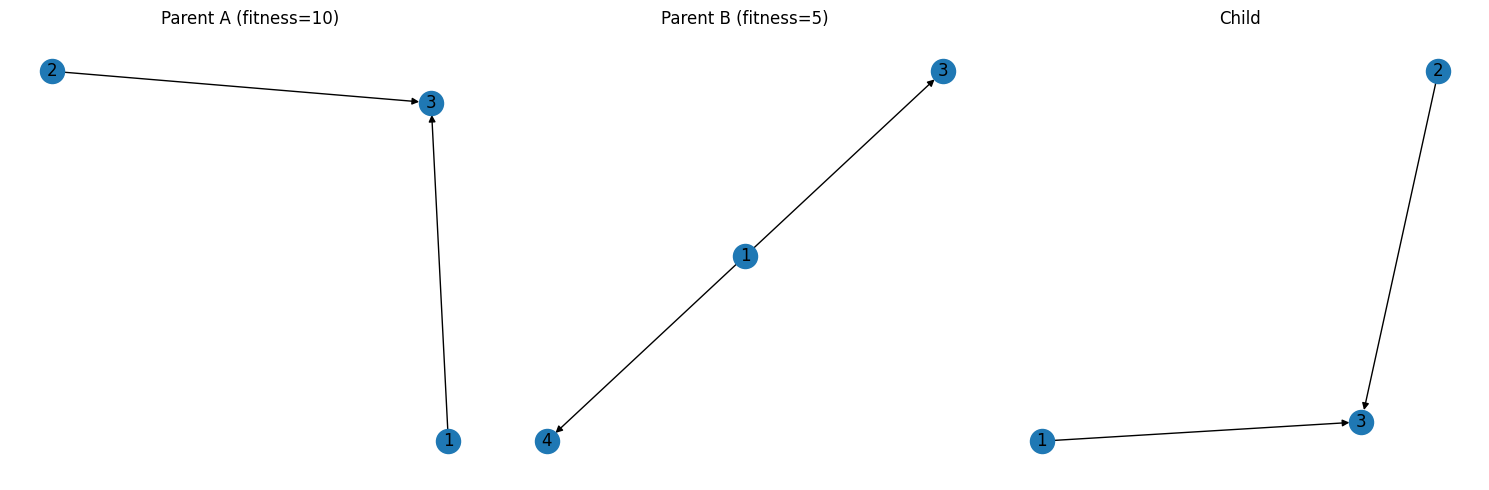

In [36]:
# nodes
node_1 = NodeGene(id=1, layer='input', activation='sigmoid', bias=0)
node_2 = NodeGene(id=2, layer='input', activation='sigmoid', bias=0)
node_3 = NodeGene(id=3, layer='hidden', activation='sigmoid', bias=0)
node_4 = NodeGene(id=4, layer='output', activation='sigmoid', bias=0)

# create connections for parent A
conn_a1 = NodeConnection(id=1, output_node_id=3, input_node_id=1, 
                        weight=0.5, enabled=True, innovation=1)
conn_a2 = NodeConnection(id=2, output_node_id=3, input_node_id=2, 
                        weight=0.5, enabled=True, innovation=2)

# create connections for parent B  
conn_b1 = NodeConnection(id=1, output_node_id=3, input_node_id=1, 
                        weight=0.5, enabled=True, innovation=1)
conn_b3 = NodeConnection(id=3, output_node_id=4, input_node_id=1, 
                        weight=0.5, enabled=True, innovation=3)

# build genomes
parent_a = Genome(nodes=[node_1, node_2, node_3], 
                connections=[conn_a1, conn_a2])
parent_a.fitness = 10

parent_b = Genome(nodes=[node_1, node_2, node_3], 
                connections=[conn_b1, conn_b3])
parent_b.fitness = 5

# create and print crossover
child = crossover(parent_a, parent_b)
print("child innovations: ", list(child.connections.keys()))
print("child node ids: ", list(child.nodes.keys()))

# plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

visualize_genome(parent_a, ax=axes[0])
axes[0].set_title("Parent A (fitness=10)")

visualize_genome(parent_b, ax=axes[1])
axes[1].set_title("Parent B (fitness=5)")

visualize_genome(child, ax=axes[2])
axes[2].set_title("Child")

plt.tight_layout()
plt.show()